In [1]:
!pip install language-tool-python
!pip install rouge
!pip install tensorflow
!pip install torch
!pip install nltk
!pip install openpyxl
!pip install transformers


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import csv
import pickle
import string
import random
import gc
import chardet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import nltk
import re
import openpyxl

nltk.download('wordnet')

from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score, single_meteor_score
from rouge import Rouge
from transformers import AutoTokenizer, AutoModelForMaskedLM
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LSTM, Concatenate, Reshape,
    BatchNormalization, Attention, GlobalAveragePooling1D
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import load_img, img_to_array, to_categorical, pad_sequences, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import mixed_precision
from openpyxl.styles import Font, PatternFill
from openpyxl.utils.exceptions import IllegalCharacterError
from PIL import ImageFile
from pickle import dump

2025-06-05 11:57:25.483520: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-05 11:57:25.505878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749117445.518449 1350772 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749117445.522155 1350772 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749117445.532557 1350772 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/sebastiano.lonardi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
print(tf.__version__)



2.19.0


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled on the GPU.")
    except RuntimeError as e:
        print(e)

Memory growth enabled on the GPU.


In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#image_dataset_path = r"/content/drive/MyDrive/LLM project/SLICES-REDUCED-JPG" 
#caption_dataset_path = r"/content/drive/MyDrive/LLM project/REPORTS-REDUCED_EN.txt" 
image_dataset_path = r"/home/sebastiano.lonardi/project/SLICES-REDUCED-JPG" 
caption_dataset_path = r"/home/sebastiano.lonardi/project/REPORTS-REDUCED_EN.txt"

In [5]:
# Function to detect encoding of the file
def detect_encoding(file_path):
    with open(file_path, 'rb') as file:
        raw_data = file.read()
    result = chardet.detect(raw_data)
    encoding = result['encoding']
    return encoding

# Function to load the caption file with detected encoding
def load_caption_file(path):
    # Detect the encoding of the file
    encoding = detect_encoding(path)

    # Dictionary to store captions
    captions_dict = {}

    # Iterate through the file using the detected encoding
    with open(path, "r", encoding=encoding) as file:
        for line in file:
            parts = line.split("\t\t")
            if len(parts) < 2: # if tab split fails, try splitting with space
                parts = line.split(maxsplit=1)
            if len(parts) == 2:
                image_id, report = parts
                captions = [caption.strip() for caption in report.split(".") if caption.strip()]
                captions_dict[image_id] = captions
            else:
                print(f"Skipping line due to unexpected format: {line.strip()}")

    return captions_dict

# Function to process group of 8 slices associated with the same report
def process_reports_in_groups(captions_dict, group_size=8):
    grouped_captions_dict = {}
    temp_dict = {}

    for key, report in captions_dict.items():
        prefix = key[:4]
        if prefix not in temp_dict:
            temp_dict[prefix] = []
        temp_dict[prefix].append((key, report))

    for prefix, items in temp_dict.items():
        for i in range(0, len(items), group_size):
            group = items[i:i + group_size]
            if len(group) == group_size:
                group_report = group[0][1]
                for key, _ in group:
                    grouped_captions_dict[key] = group_report

    return grouped_captions_dict

In [21]:
captions_dict = load_caption_file(caption_dataset_path)

grouped_captions_dict = process_reports_in_groups(captions_dict)

In [ ]:
import os
import random
import numpy as np
from PIL import Image, ImageEnhance, ImageOps
import cv2


images_dir = "/home/sebastiano.lonardi/project/SLICES-REDUCED-JPG"         
augmented_dir = "/home/sebastiano.lonardi/project/SLICES_AUGMENTED-JPG"    
start_new_id = 541                     




augmented_captions_dict = {}


def add_gaussian_noise(img, std=5):
    np_img = np.array(img).astype(np.float32)
    noise = np.random.normal(0, std, np_img.shape)
    noisy_img = np.clip(np_img + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_img).convert("L")

def add_motion_blur(img, kernel_size=5):
    img_np = np.array(img)
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    kernel /= kernel_size
    blurred = cv2.filter2D(img_np, -1, kernel)
    return Image.fromarray(blurred.astype(np.uint8)).convert("L")

def random_mask(img, num_patches=1):
    img_np = np.array(img)
    h, w = img_np.shape
    for _ in range(num_patches):
        x = random.randint(0, w - 30)
        y = random.randint(0, h - 30)
        mask_w = random.randint(10, 30)
        mask_h = random.randint(10, 30)
        img_np[y:y+mask_h, x:x+mask_w] = 0
    return Image.fromarray(img_np).convert("L")

def elastic_deformation(img, alpha=20, sigma=6):
    img_np = np.array(img).astype(np.float32)
    shape = img_np.shape

    dx = cv2.GaussianBlur((np.random.rand(*shape) * 2 - 1), (17, 17), sigma) * alpha
    dy = cv2.GaussianBlur((np.random.rand(*shape) * 2 - 1), (17, 17), sigma) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    map_x = np.clip((x + dx).astype(np.float32), 0, shape[1]-1)
    map_y = np.clip((y + dy).astype(np.float32), 0, shape[0]-1)

    deformed = cv2.remap(img_np, map_x, map_y, interpolation=cv2.INTER_LINEAR)
    return Image.fromarray(deformed.astype(np.uint8)).convert("L")

def generate_augmentation_params():
    return {
        "flip_h": random.random() < 0.4,
        "flip_v": random.random() < 0.4,
        "contrast": random.uniform(0.7, 1.4) if random.random() < 0.5 else None,
        "brightness": random.uniform(0.8, 1.3) if random.random() < 0.5 else None,
        "gaussian_noise": random.uniform(3, 8) if random.random() < 0.3 else None,
        "motion_blur": random.choice([3, 5, 7]) if random.random() < 0.3 else None,
        "elastic": random.random() < 0.2,
        "mask": random.random() < 0.2
    }

def apply_augmentations(img, params):
    img = img.convert("L")  # Grayscale
    if params["flip_h"]:
        img = ImageOps.mirror(img)
    if params["flip_v"]:
        img = ImageOps.flip(img)
    if params["contrast"]:
        img = ImageEnhance.Contrast(img).enhance(params["contrast"])
    if params["brightness"]:
        img = ImageEnhance.Brightness(img).enhance(params["brightness"])
    if params["gaussian_noise"]:
        img = add_gaussian_noise(img, std=params["gaussian_noise"])
    if params["motion_blur"]:
        img = add_motion_blur(img, kernel_size=params["motion_blur"])
    if params["elastic"]:
        img = elastic_deformation(img)
    if params["mask"]:
        img = random_mask(img)
    return img



for idx, old_id_num in enumerate(range(1, 541)):
    old_id = f"{old_id_num:04d}"
    new_id = f"{start_new_id + idx:04d}"
    params = generate_augmentation_params()

    for slice_num in range(2, 10):
        old_slice_name = f"{old_id}_slice_{slice_num:04d}.jpg"
        old_slice_path = os.path.join(images_dir, old_slice_name)

        if not os.path.exists(old_slice_path):
            print(f"⚠️ Slice mancante: {old_slice_name}")
            continue

        try:
            img = Image.open(old_slice_path)
            augmented_img = apply_augmentations(img, params)

            # Nuovo nome immagine
            new_slice_name = f"{new_id}_slice_{slice_num:04d}.jpg"
            new_slice_path = os.path.join(augmented_dir, new_slice_name)

            # Salva immagine
            augmented_img.save(new_slice_path, quality=95)

            # Copia la caption associata
            old_key = f"{old_id}_slice_{slice_num:04d}"
            new_key = f"{new_id}_slice_{slice_num:04d}"

            if old_key in captions_dict:
                augmented_captions_dict[new_key] = captions_dict[old_key]
            else:
                print(f"Nessuna caption trovata per {old_key}")

        except Exception as e:
            print(f"Errore con {old_slice_name}: {e}")

print("Augmentazione completata.")


⚠️ Slice mancante: 0005_slice_0002.jpg
⚠️ Slice mancante: 0005_slice_0003.jpg
⚠️ Slice mancante: 0005_slice_0004.jpg
⚠️ Slice mancante: 0005_slice_0005.jpg
⚠️ Slice mancante: 0005_slice_0006.jpg
⚠️ Slice mancante: 0005_slice_0007.jpg
⚠️ Slice mancante: 0005_slice_0008.jpg
⚠️ Slice mancante: 0005_slice_0009.jpg
⚠️ Slice mancante: 0022_slice_0002.jpg
⚠️ Slice mancante: 0022_slice_0003.jpg
⚠️ Slice mancante: 0022_slice_0004.jpg
⚠️ Slice mancante: 0022_slice_0005.jpg
⚠️ Slice mancante: 0022_slice_0006.jpg
⚠️ Slice mancante: 0022_slice_0007.jpg
⚠️ Slice mancante: 0022_slice_0008.jpg
⚠️ Slice mancante: 0022_slice_0009.jpg
⚠️ Slice mancante: 0037_slice_0002.jpg
⚠️ Slice mancante: 0037_slice_0003.jpg
⚠️ Slice mancante: 0037_slice_0004.jpg
⚠️ Slice mancante: 0037_slice_0005.jpg
⚠️ Slice mancante: 0037_slice_0006.jpg
⚠️ Slice mancante: 0037_slice_0007.jpg
⚠️ Slice mancante: 0037_slice_0008.jpg
⚠️ Slice mancante: 0037_slice_0009.jpg
⚠️ Slice mancante: 0039_slice_0002.jpg
⚠️ Slice mancante: 0039_s

⚠️ Slice mancante: 0076_slice_0002.jpg
⚠️ Slice mancante: 0076_slice_0003.jpg
⚠️ Slice mancante: 0076_slice_0004.jpg
⚠️ Slice mancante: 0076_slice_0005.jpg
⚠️ Slice mancante: 0076_slice_0006.jpg
⚠️ Slice mancante: 0076_slice_0007.jpg
⚠️ Slice mancante: 0076_slice_0008.jpg
⚠️ Slice mancante: 0076_slice_0009.jpg
⚠️ Slice mancante: 0077_slice_0002.jpg
⚠️ Slice mancante: 0077_slice_0003.jpg
⚠️ Slice mancante: 0077_slice_0004.jpg
⚠️ Slice mancante: 0077_slice_0005.jpg
⚠️ Slice mancante: 0077_slice_0006.jpg
⚠️ Slice mancante: 0077_slice_0007.jpg
⚠️ Slice mancante: 0077_slice_0008.jpg
⚠️ Slice mancante: 0077_slice_0009.jpg
⚠️ Slice mancante: 0084_slice_0002.jpg
⚠️ Slice mancante: 0084_slice_0003.jpg
⚠️ Slice mancante: 0084_slice_0004.jpg
⚠️ Slice mancante: 0084_slice_0005.jpg
⚠️ Slice mancante: 0084_slice_0006.jpg
⚠️ Slice mancante: 0084_slice_0007.jpg
⚠️ Slice mancante: 0084_slice_0008.jpg
⚠️ Slice mancante: 0084_slice_0009.jpg
⚠️ Slice mancante: 0091_slice_0002.jpg
⚠️ Slice mancante: 0091_s

In [11]:
grouped_augmented_captions_dict = process_reports_in_groups(augmented_captions_dict)

In [ ]:
print("Number of images in the grouped_captions_dict dictionary:", len(grouped_captions_dict))

#for image_id, captions in list(grouped_captions_dict.items())[:100]:
for image_id, captions in list(grouped_captions_dict.items()):
     print(image_id, ":", captions)
print()

'''for image_id in list(grouped_captions_dict.keys())[:100]:
    print(image_id)
print()'''

In [12]:
print("Number of images in the grouped_captions_dict dictionary:", len(grouped_augmented_captions_dict))

#for image_id, captions in list(grouped_captions_dict.items())[:100]:
for image_id, captions in list(grouped_augmented_captions_dict.items()):
     print(image_id, ":", captions)
print()

'''for image_id in list(grouped_captions_dict.keys())[:100]:
    print(image_id)
print()'''

Number of images in the grouped_captions_dict dictionary: 4000
0541_slice_0002 : ['No ongoing hemorrhagic effusions', 'No intra or extra-axial acute focal densitometric alterations', 'Small ischemic sequelae in the basal nuclei bilaterally', 'Midline on axis with ventricular system on site, of regular morphology', 'Subarachnoid spaces of the convexity, cranial base, and cisternal regions are within normal limits', 'Vascular calcifications']
0541_slice_0003 : ['No ongoing hemorrhagic effusions', 'No intra or extra-axial acute focal densitometric alterations', 'Small ischemic sequelae in the basal nuclei bilaterally', 'Midline on axis with ventricular system on site, of regular morphology', 'Subarachnoid spaces of the convexity, cranial base, and cisternal regions are within normal limits', 'Vascular calcifications']
0541_slice_0004 : ['No ongoing hemorrhagic effusions', 'No intra or extra-axial acute focal densitometric alterations', 'Small ischemic sequelae in the basal nuclei bilatera

'for image_id in list(grouped_captions_dict.keys())[:100]:\n    print(image_id)\nprint()'

In [13]:
print('"' + list(grouped_augmented_captions_dict.keys())[0] + '" : ')
for caption in grouped_augmented_captions_dict[list(grouped_augmented_captions_dict.keys())[0]]:
    print(caption)
print()

print('"' + list(grouped_augmented_captions_dict.keys())[50] + '" : ')
for caption in grouped_augmented_captions_dict[list(grouped_augmented_captions_dict.keys())[50]]:
    print(caption)
print()

print('"' + list(grouped_augmented_captions_dict.keys())[100] + '" : ')
for caption in grouped_augmented_captions_dict[list(grouped_augmented_captions_dict.keys())[100]]:
    print(caption)
print()

"0541_slice_0002" : 
No ongoing hemorrhagic effusions
No intra or extra-axial acute focal densitometric alterations
Small ischemic sequelae in the basal nuclei bilaterally
Midline on axis with ventricular system on site, of regular morphology
Subarachnoid spaces of the convexity, cranial base, and cisternal regions are within normal limits
Vascular calcifications

"0548_slice_0004" : 
Evident dilation of the ventricular system (which remains on axis), with reduction in the representation of the basal cisterns, particularly the prepontine cistern
A mild presence of hemoventricle is noted
Residual hemorrhagic effusions are present along with other observed findings

"0554_slice_0006" : 
TDM findings show no significant densitometric alterations in the encephalic tissue of supratentorial or infratentorial regions, with no evidence of developing ischemic foci or active hemorrhages



In [8]:
print('"' + list(grouped_captions_dict.keys())[0] + '" : ')
for caption in grouped_captions_dict[list(grouped_captions_dict.keys())[0]]:
    print(caption)
print()

print('"' + list(grouped_captions_dict.keys())[50] + '" : ')
for caption in grouped_captions_dict[list(grouped_captions_dict.keys())[50]]:
    print(caption)
print()

print('"' + list(grouped_captions_dict.keys())[100] + '" : ')
for caption in grouped_captions_dict[list(grouped_captions_dict.keys())[100]]:
    print(caption)
print()

"0001_slice_0002" : 
No ongoing hemorrhagic effusions
No intra or extra-axial acute focal densitometric alterations
Small ischemic sequelae in the basal nuclei bilaterally
Midline on axis with ventricular system on site, of regular morphology
Subarachnoid spaces of the convexity, cranial base, and cisternal regions are within normal limits
Vascular calcifications

"0008_slice_0004" : 
Evident dilation of the ventricular system (which remains on axis), with reduction in the representation of the basal cisterns, particularly the prepontine cistern
A mild presence of hemoventricle is noted
Residual hemorrhagic effusions are present along with other observed findings

"0014_slice_0006" : 
TDM findings show no significant densitometric alterations in the encephalic tissue of supratentorial or infratentorial regions, with no evidence of developing ischemic foci or active hemorrhages



In [22]:
# Make a dictionary to store the cleaned captions
new_captions_dict = {}

# Prepare translation table for removing punctuation
# Third argument is the list of punctuations we want to remove
table = str.maketrans('', '', string.punctuation)

# Loop through the dictionary
for caption_id, caption_list in grouped_captions_dict.items():
    cleaned_captions = []
    for caption_text in caption_list:
        # Tokenize the caption_text
        caption_text = caption_text.split()
        # Convert it into lower case
        caption_text = [token.lower() for token in caption_text]
        # Remove punctuation from each token
        caption_text = [token.translate(table) for token in caption_text]
        # Remove all the single letter tokens
        caption_text = [token for token in caption_text if len(token) > 1]
        # Join the cleaned tokens back into a single string
        cleaned_caption = ' '.join(caption_text)
        # Add startseq and endseq to the caption
        cleaned_caption = 'startseq ' + cleaned_caption + ' endseq'
        # Append the cleaned caption to the list
        cleaned_captions.append(cleaned_caption)

    # Store the cleaned captions for the current image
    new_captions_dict[caption_id] = cleaned_captions

In [14]:
# Make a dictionary to store the cleaned captions
new_augmented_captions_dict = {}

# Prepare translation table for removing punctuation
# Third argument is the list of punctuations we want to remove
table = str.maketrans('', '', string.punctuation)

# Loop through the dictionary
for caption_id, caption_list in grouped_augmented_captions_dict.items():
    cleaned_captions = []
    for caption_text in caption_list:
        # Tokenize the caption_text
        caption_text = caption_text.split()
        # Convert it into lower case
        caption_text = [token.lower() for token in caption_text]
        # Remove punctuation from each token
        caption_text = [token.translate(table) for token in caption_text]
        # Remove all the single letter tokens
        caption_text = [token for token in caption_text if len(token) > 1]
        # Join the cleaned tokens back into a single string
        cleaned_caption = ' '.join(caption_text)
        # Add startseq and endseq to the caption
        cleaned_caption = 'startseq ' + cleaned_caption + ' endseq'
        # Append the cleaned caption to the list
        cleaned_captions.append(cleaned_caption)

    # Store the cleaned captions for the current image
    new_augmented_captions_dict[caption_id] = cleaned_captions

In [23]:
del grouped_captions_dict # to delete unwanted
#gc.collect()

In [15]:
del grouped_augmented_captions_dict

In [17]:
print('"' + list(new_augmented_captions_dict.keys())[0] + '" : ')
for caption in new_augmented_captions_dict[list(new_augmented_captions_dict.keys())[0]]:
    print(caption)
print()

print('"' + list(new_augmented_captions_dict.keys())[50] + '" : ')
for caption in new_augmented_captions_dict[list(new_augmented_captions_dict.keys())[50]]:
    print(caption)
print()

print('"' + list(new_augmented_captions_dict.keys())[100] + '" : ')
for caption in new_augmented_captions_dict[list(new_augmented_captions_dict.keys())[100]]:
    print(caption)
print()

"0541_slice_0002" : 
startseq no ongoing hemorrhagic effusions endseq
startseq no intra or extraaxial acute focal densitometric alterations endseq
startseq small ischemic sequelae in the basal nuclei bilaterally endseq
startseq midline on axis with ventricular system on site of regular morphology endseq
startseq subarachnoid spaces of the convexity cranial base and cisternal regions are within normal limits endseq
startseq vascular calcifications endseq

"0548_slice_0004" : 
startseq evident dilation of the ventricular system which remains on axis with reduction in the representation of the basal cisterns particularly the prepontine cistern endseq
startseq mild presence of hemoventricle is noted endseq
startseq residual hemorrhagic effusions are present along with other observed findings endseq

"0554_slice_0006" : 
startseq tdm findings show no significant densitometric alterations in the encephalic tissue of supratentorial or infratentorial regions with no evidence of developing isch

In [11]:
print('"' + list(new_captions_dict.keys())[0] + '" : ')
for caption in new_captions_dict[list(new_captions_dict.keys())[0]]:
    print(caption)
print()

print('"' + list(new_captions_dict.keys())[50] + '" : ')
for caption in new_captions_dict[list(new_captions_dict.keys())[50]]:
    print(caption)
print()

print('"' + list(new_captions_dict.keys())[100] + '" : ')
for caption in new_captions_dict[list(new_captions_dict.keys())[100]]:
    print(caption)
print()

"0001_slice_0002" : 
startseq no ongoing hemorrhagic effusions endseq
startseq no intra or extraaxial acute focal densitometric alterations endseq
startseq small ischemic sequelae in the basal nuclei bilaterally endseq
startseq midline on axis with ventricular system on site of regular morphology endseq
startseq subarachnoid spaces of the convexity cranial base and cisternal regions are within normal limits endseq
startseq vascular calcifications endseq

"0008_slice_0004" : 
startseq evident dilation of the ventricular system which remains on axis with reduction in the representation of the basal cisterns particularly the prepontine cistern endseq
startseq mild presence of hemoventricle is noted endseq
startseq residual hemorrhagic effusions are present along with other observed findings endseq

"0014_slice_0006" : 
startseq tdm findings show no significant densitometric alterations in the encephalic tissue of supratentorial or infratentorial regions with no evidence of developing isch

In [24]:
# Compute the max number of captions per image
Nmax = max(len(captions) for captions in new_captions_dict.values())
Nmax

9

In [25]:
new_captions_dict.update(new_augmented_captions_dict)

In [26]:
paths = [image_dataset_path, augmented_dir]

# Crea la lista delle immagini con didascalie
caption_images_list = []
image_index = list(new_captions_dict.keys())

for path in paths:
    caption_images_list.extend(
        [image.split('.')[0] for image in os.listdir(path) if image.split('.')[0] in image_index]
    )

In [13]:
# Make a list of only those images who have captions
caption_images_list = []
image_index = list(new_captions_dict.keys())
caption_images_list = [image.split('.')[0] for image in os.listdir(image_dataset_path) if image.split('.')[0] in image_index]

In [27]:
len(caption_images_list)

8000

In [28]:
# Group frames based on the first 4 numbers of their identifiers
prefix_groups = {}
for image in caption_images_list:
    prefix = image[:4]
    if prefix not in prefix_groups:
        prefix_groups[prefix] = []
    prefix_groups[prefix].append(image)
for prefix, group in prefix_groups.items():
    print(prefix, ":" , group)
grouped_images = []
for group in prefix_groups.values():
    if len(group) == 8: # make sure there are exactly 8 images per group
        grouped_images.append(group)

0001 : ['0001_slice_0002', '0001_slice_0004', '0001_slice_0003', '0001_slice_0005', '0001_slice_0007', '0001_slice_0008', '0001_slice_0009', '0001_slice_0006']
0002 : ['0002_slice_0004', '0002_slice_0003', '0002_slice_0002', '0002_slice_0005', '0002_slice_0008', '0002_slice_0007', '0002_slice_0006', '0002_slice_0009']
0003 : ['0003_slice_0002', '0003_slice_0003', '0003_slice_0004', '0003_slice_0005', '0003_slice_0006', '0003_slice_0007', '0003_slice_0009', '0003_slice_0008']
0004 : ['0004_slice_0002', '0004_slice_0003', '0004_slice_0004', '0004_slice_0005', '0004_slice_0006', '0004_slice_0007', '0004_slice_0008', '0004_slice_0009']
0006 : ['0006_slice_0004', '0006_slice_0005', '0006_slice_0002', '0006_slice_0003', '0006_slice_0006', '0006_slice_0007', '0006_slice_0008', '0006_slice_0009']
0007 : ['0007_slice_0004', '0007_slice_0003', '0007_slice_0005', '0007_slice_0002', '0007_slice_0006', '0007_slice_0007', '0007_slice_0009', '0007_slice_0008']
0008 : ['0008_slice_0002', '0008_slice_0

In [16]:
random.seed(12)
random.shuffle(grouped_images)

# Flatten the list of groups back to a list of images
flattened_images = [image for group in grouped_images for image in group]

num_test_groups = int(0.20 * len(grouped_images)) # 20%

test_groups = grouped_images[:num_test_groups]
train_validate_groups = grouped_images[num_test_groups:]

# Flatten the groups into image lists for train and test
test_images = [image for group in test_groups for image in group]
train_validate_images = [image for group in train_validate_groups for image in group]

print(f"Number of training and validation slices: {len(train_validate_images)}")
print(f"Number of test slices: {len(test_images)}")

# Shuffle train/validation and test images
random.shuffle(train_validate_images)
random.shuffle(test_images)

Number of training and validation slices: 3200
Number of test slices: 800


In [20]:
'''
test_prefixes = sorted(set(image[:4] for image in test_images))
print("Prefixes of test scans:")
for prefix in test_prefixes:
    print(prefix)'''

'\ntest_prefixes = sorted(set(image[:4] for image in test_images))\nprint("Prefixes of test scans:")\nfor prefix in test_prefixes:\n    print(prefix)'

In [ ]:
# Extract features from each image in the directory
def extract_features(directory, image_keys):
    
    base_model = VGG16(weights='imagenet', include_top=False)
    
    
    conv_output = base_model.layers[-1].output
    conv_model = Model(inputs=base_model.input, outputs=conv_output)

    # 3. Modello completo per ottenere fc2
    full_model = VGG16(weights='imagenet', include_top=True)
    fc2_model = Model(inputs=full_model.input, outputs=full_model.get_layer('fc2').output)

    features = dict()

    for name in image_keys:
        filename = os.path.join(directory, name + '.jpg')
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)

        # Ottieni feature da conv e da fc2
        conv_feat = conv_model.predict(image, verbose=0)   # (1, 7, 7, 512)
        dense_feat = fc2_model.predict(image, verbose=0)   # (1, 4096)

        # Rimuovi batch dimensione
        conv_feat = np.squeeze(conv_feat, axis=0)   # (7, 7, 512)
        dense_feat = np.squeeze(dense_feat, axis=0) # (4096,)

        print(conv_feat.shape)
        print(dense_feat.shape)

        # Se ti serve per visual attention → reshape in (49, 512)
        conv_feat = conv_feat.reshape((49, 512))

        image_id = name.split('.')[0]
        features[image_id] = {
            'conv': conv_feat,     # visual attention
            'dense': dense_feat    # self text attention
        }

    return features

ImageFile.LOAD_TRUNCATED_IMAGES = True # to fix 'OSError: broken data stream when reading image file'


# Extracting image features for train_validate_images
train_validate_features = extract_features(image_dataset_path, train_validate_images)

# Save the extracted features
with open(r'/home/sebastiano.lonardi/project/train-val-features.pkl', 'wb') as f: 
    dump(train_validate_features, f)

I0000 00:00:1749045510.104084 1222418 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43622 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:a1:00.0, compute capability: 8.9
I0000 00:00:1749045510.107762 1222418 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43622 MB memory:  -> device: 1, name: NVIDIA L40S, pci bus id: 0000:c1:00.0, compute capability: 8.9


I0000 00:00:1749045523.404984 1223409 service.cc:152] XLA service 0x7f06d4015a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749045523.405006 1223409 service.cc:160]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
I0000 00:00:1749045523.405008 1223409 service.cc:160]   StreamExecutor device (1): NVIDIA L40S, Compute Capability 8.9
2025-06-04 15:58:43.411549: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749045523.461612 1223409 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1749045523.944486 1223409 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-06-04 15:58:44.551827: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function

(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)
(7, 7, 512)
(4096,)


In [ ]:
def load_large_pickle(file_path):
    with open(file_path, 'rb') as file:
        unpickler = pickle.Unpickler(file)
        return unpickler.load()

train_validate_features = load_large_pickle(r'/home/sebastiano.lonardi/project/train-val-features.pkl')

print(len(train_validate_features))
image_id = '0001_slice_0002'  

print("Features conv shape:", train_validate_features[image_id]['conv'].shape)
print("Features dense shape:", train_validate_features[image_id]['dense'].shape)


3200
Features conv shape: (49, 512)
Features dense shape: (4096,)


In [21]:
train_validate_features_text = {}
train_validate_features_visual = {}

for image_id, features in train_validate_features.items():
    train_validate_features_visual[image_id] = features['conv']
    train_validate_features_text[image_id] = features['dense']

In [22]:
del captions_dict
#gc.collect()

In [23]:
train_validate_image_caption = {}

for image, caption in new_captions_dict.items():
    # Check whether the image is available in both train_validate_images list and train_validate_features dictionary
    if image in train_validate_images and image in list(train_validate_features_text.keys()):
        train_validate_image_caption.update({image: caption})

len(train_validate_image_caption)



3200

In [ ]:
# Initialise tokenizer
tokenizer = Tokenizer()

# Create word count dictionary on all the captions
all_captions = [caption for captions_list in new_captions_dict.values() for caption in captions_list]
tokenizer.fit_on_texts(all_captions)


vocab_len = len(tokenizer.word_index) + 1

# Store the length of the maximum sentence
max_len = max(
    max(len(caption.split()) for caption in captions_list) for captions_list in train_validate_image_caption.values()) # iteration over all the captions associated with all the images and finding of the maximum length among all the captions
                                                                                                                       # this maximum length will be used as the maximum length of input sequences during data preparation

# Print some tokenized sequences
for caption in all_captions[:6]: # only the first 6 sequences (the one associated to the first image) to avoid too long output
    sequence = tokenizer.texts_to_sequences([caption])[0]
    print("Original caption:", caption)
    print("Tokenized sequence:", sequence)
    print()

Original caption: startseq no ongoing hemorrhagic effusions endseq
Tokenized sequence: [1, 5, 36, 22, 27, 2]

Original caption: startseq no intra or extraaxial acute focal densitometric alterations endseq
Tokenized sequence: [1, 5, 15, 12, 13, 21, 25, 28, 23, 2]

Original caption: startseq small ischemic sequelae in the basal nuclei bilaterally endseq
Tokenized sequence: [1, 105, 45, 94, 16, 4, 51, 147, 148, 2]

Original caption: startseq midline on axis with ventricular system on site of regular morphology endseq
Tokenized sequence: [1, 11, 6, 8, 24, 9, 10, 6, 34, 3, 37, 29, 2]

Original caption: startseq subarachnoid spaces of the convexity cranial base and cisternal regions are within normal limits endseq
Tokenized sequence: [1, 26, 17, 3, 4, 32, 35, 38, 7, 44, 39, 14, 19, 18, 20, 2]

Original caption: startseq vascular calcifications endseq
Tokenized sequence: [1, 58, 87, 2]



In [25]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [26]:
def data_generator_modified(image_keys, Nmax, group_size=8, batch_size=1):
    while True:
        for i in range(0, len(image_keys), batch_size * group_size):
            conv_x = [[] for _ in range(group_size)]
            dense_x = [[] for _ in range(group_size)]
            x2, y = [[] for _ in range(Nmax)], [[] for _ in range(Nmax)]

            batch_keys = image_keys[i:i + batch_size * group_size]
            if len(batch_keys) < batch_size * group_size:
                break

            for j in range(0, len(batch_keys), group_size):
                group_keys = batch_keys[j:j + group_size]
                if len(group_keys) < group_size:
                    break

                for idx, image in enumerate(group_keys):
                    conv_feat = train_validate_features_visual[image]   # (49, 512)
                    dense_feat = train_validate_features_text[image]    # (4096,)

                    captions_list = train_validate_image_caption.get(image, [])
                    for m, caption in enumerate(captions_list):
                        seq = tokenizer.texts_to_sequences([caption.split()])[0]
                        for k in range(1, len(seq)):
                            x2_seq = pad_sequences([seq[:k]], maxlen=max_len)[0]
                            y_seq = tf.keras.utils.to_categorical(seq[k], num_classes=vocab_len)

                            for g in range(group_size):
                                conv_x[g].append(conv_feat)
                                dense_x[g].append(dense_feat)

                            for n in range(Nmax):
                                if n == m:
                                    x2[n].append(x2_seq)
                                    y[n].append(y_seq)
                                else:
                                    x2[n].append(np.zeros((max_len,), dtype=np.int32))
                                    y[n].append(np.zeros((vocab_len,), dtype=np.float32))

            yield (
                tuple(np.array(x, dtype=np.float32) for x in conv_x + dense_x) +  
                tuple(np.array(x, dtype=np.int32) for x in x2),
                tuple(np.array(y_seq, dtype=np.float32) for y_seq in y)
            )

In [27]:
total_train_validate = len(train_validate_images)
num_validate_images = int(0.15 * total_train_validate)
num_train_images = total_train_validate - num_validate_images

group_size = 8
batch_size = 4

train_tf_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator_modified(train_validate_images[:num_train_images], Nmax,group_size=group_size, batch_size=batch_size),
    output_signature=(
        tuple(tf.TensorSpec(shape=(None, 49, 512), dtype=tf.float32) for _ in range(group_size)) +
        tuple(tf.TensorSpec(shape=(None, 4096), dtype=tf.float32) for _ in range(group_size)) +
        tuple(tf.TensorSpec(shape=(None, max_len), dtype=tf.int32) for _ in range(Nmax)),
        tuple(tf.TensorSpec(shape=(None, vocab_len), dtype=tf.float32) for _ in range(Nmax))
    )
).prefetch(tf.data.AUTOTUNE)

validate_tf_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator_modified(train_validate_images[num_train_images:], Nmax, group_size=group_size,batch_size=batch_size),
    output_signature=(
        tuple(tf.TensorSpec(shape=(None, 49, 512), dtype=tf.float32) for _ in range(group_size)) +
        tuple(tf.TensorSpec(shape=(None, 4096), dtype=tf.float32) for _ in range(group_size)) +
        tuple(tf.TensorSpec(shape=(None, max_len), dtype=tf.int32) for _ in range(Nmax)),
        tuple(tf.TensorSpec(shape=(None, vocab_len), dtype=tf.float32) for _ in range(Nmax))
    )
).prefetch(tf.data.AUTOTUNE)

In [28]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units, name=None):
        super(BahdanauAttention, self).__init__(name=name)
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, features, hidden):
        # features shape: (batch_size, 49, 512)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)  # (batch_size, 1, hidden_size)

        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))  # (batch_size, 49, units)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)  # (batch_size, 49, 1)

        # Compute context vector
        context_vector = attention_weights * features  # (batch_size, 49, 512)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # (batch_size, 512)

        return context_vector, attention_weights

In [29]:
from tensorflow.keras.layers import Lambda

def define_model_modified(max_len, vocab_size, Nmax, group_size=8):
    visual_inputs = [Input(shape=(49, 512), name=f'visual_input_{i}') for i in range(group_size)]

    input_images = [Input(shape=(4096,), name=f'dense_input_{i}') for i in range(group_size)]

    # Preprocessing immagini globali
    concatenated_images = Concatenate()(input_images)
    image_features = Dense(2048, activation='relu', kernel_regularizer=l2(1e-3))(concatenated_images)
    image_features = BatchNormalization()(image_features)
    image_features = Dropout(0.6)(image_features)

    input_captions = []
    outputs = []

    # Istanza di visual attention condivisa
    visual_attention = BahdanauAttention(units=128)

    for i in range(Nmax):
        # Input caption
        input_caption = Input(shape=(max_len,), name=f'caption_input_{i}')
        input_captions.append(input_caption)

        # Reshape per LSTM
        reshaped_input_caption = Reshape((max_len, 1))(input_caption)

        # Decoder testuale (LSTM)
        lstm_seq = LSTM(128, return_sequences=True, kernel_regularizer=l2(1e-4), recurrent_dropout=0.3, name=f'lstm_{i}')(reshaped_input_caption)

        # Self-attention testuale
        textual_context = Attention(name=f'self_attention_{i}')([lstm_seq, lstm_seq])
        textual_context = GlobalAveragePooling1D()(textual_context)
        textual_context = Dropout(0.5)(textual_context)

        # Visual context (Bahdanau Attention su tutte le immagini del gruppo)
        visual_contexts = []
        for v_input in visual_inputs:
            # hidden state: media della sequenza LSTM → shape (batch, 128)
            hidden_state = Lambda(lambda x: tf.reduce_mean(x, axis=1))(lstm_seq)
            context_vector, _ = visual_attention(v_input, hidden_state)
            visual_contexts.append(context_vector)

        combined_visual_context = Concatenate()(visual_contexts)

        # Combina visual + testuale + globale (fc2)
        combined = Concatenate()([image_features, combined_visual_context, textual_context])

        dense = Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(combined)
        dense = Dropout(0.6)(dense)
        output = Dense(vocab_size, activation='softmax')(dense)
        outputs.append(output)

    # Tutti gli input
    model_inputs = visual_inputs + input_images + input_captions
    model = Model(inputs=model_inputs, outputs=outputs)

    return model



vocab_size = vocab_len
model = define_model_modified(max_len, vocab_size, Nmax, group_size=8)

optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)

model.compile(optimizer=optimizer, loss='categorical_crossentropy')

#model.summary()

In [ ]:
def define_model(max_len, vocab_size, Nmax, group_size=8):
    input_images = [Input(shape=(4096,)) for _ in range(group_size)]

    concatenated_images = Concatenate()(input_images)
    image_features = Dense(2048, activation='relu', kernel_regularizer=l2(1e-4))(concatenated_images)
    image_features = BatchNormalization()(image_features)
    image_features = Dropout(0.4)(image_features)

    input_captions = []
    outputs = []

    for i in range(Nmax):
        input_caption = Input(shape=(max_len,))
        input_captions.append(input_caption)

        reshaped_input_caption = Reshape((max_len, 1))(input_caption)

        # LSTM that returns the entire sequence
        lstm_seq = LSTM(128, return_sequences=True, recurrent_dropout=0.3, name=f'lstm_{i}')(reshaped_input_caption)
        attention_output = Attention(name=f'attention_{i}')([lstm_seq, lstm_seq])
        context_vector = GlobalAveragePooling1D()(attention_output)
        context_vector = Dropout(0.4)(context_vector)

        combined_features = Concatenate()([image_features, context_vector])

        dense = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(combined_features)
        dense = Dropout(0.3)(dense)
        output = Dense(vocab_size, activation='softmax')(dense)
        outputs.append(output)

    model = tf.keras.Model(inputs=input_images + input_captions, outputs=outputs)

    return model

vocab_size = vocab_len
model = define_model(max_len, vocab_size, Nmax, group_size=8)

optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)

model.compile(optimizer=optimizer, loss='categorical_crossentropy')

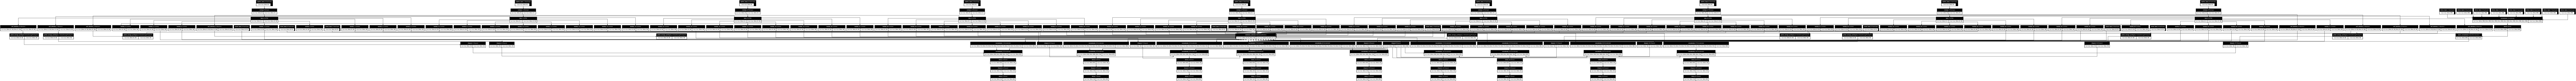

In [30]:

plot_model(
    model,
    to_file='model-with-attention.png',
    show_shapes=True,
    show_layer_names=True,
    #expand_nested=True,
    dpi=100
)

In [ ]:
checkpoint_cb = ModelCheckpoint(
    '/home/sebastiano.lonardi/project/checkpoint-with-attention-EN.weights.h5', 
    save_best_only=False,
    save_weights_only=True,
    save_freq='epoch'
)

earlystop_cb = EarlyStopping(patience=5, restore_best_weights=True)

callbacks = [checkpoint_cb, earlystop_cb]

In [32]:
history = model.fit(
    train_tf_dataset,
    epochs=100,
    validation_data=validate_tf_dataset,
    steps_per_epoch=num_train_images // batch_size,
    validation_steps=num_validate_images // batch_size,
    callbacks=callbacks
)

Epoch 1/100


2025-06-04 16:08:34.733919: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


680/680 ━━━━━━━━━━━━━━━━━━━━ 395s 536ms/step - dense_11_loss: 1.0590 - dense_13_loss: 0.4510 - dense_15_loss: 0.1171 - dense_17_loss: 0.0447 - dense_19_loss: 0.0131 - dense_21_loss: 0.0046 - dense_5_loss: 1.6340 - dense_7_loss: 1.5222 - dense_9_loss: 1.4552 - loss: 9.3762 - val_dense_11_loss: 0.6110 - val_dense_13_loss: 0.2893 - val_dense_15_loss: 0.0791 - val_dense_17_loss: 0.0119 - val_dense_19_loss: 8.7436e-04 - val_dense_21_loss: 0.0000e+00 - val_dense_5_loss: 0.9531 - val_dense_7_loss: 0.9471 - val_dense_9_loss: 0.9505 - val_loss: 4.3628
Epoch 2/100
680/680 ━━━━━━━━━━━━━━━━━━━━ 370s 544ms/step - dense_11_loss: 0.6391 - dense_13_loss: 0.2891 - dense_15_loss: 0.0787 - dense_17_loss: 0.0256 - dense_19_loss: 0.0073 - dense_21_loss: 0.0023 - dense_5_loss: 1.0708 - dense_7_loss: 0.9489 - dense_9_loss: 0.9505 - loss: 4.4319 - val_dense_11_loss: 0.5605 - val_dense_13_loss: 0.2631 - val_dense_15_loss: 0.0748 - val_dense_17_loss: 0.0103 - val_dense_19_loss: 7.5277e-04 - val_dense_21_loss: 0

In [34]:
model.save('.../model-weights-with-visual-attention-EN.h5')

In [ ]:
model.load_weights('/home/sebastiano.lonardi/project/checkpoint-with-attention-EN.weights.h5')

history = model.fit(
    train_tf_dataset,
    initial_epoch=9, 
    epochs=100,
    validation_data=validate_tf_dataset,
    steps_per_epoch=num_train_images // batch_size,
    validation_steps=num_validate_images // batch_size,
    callbacks=callbacks
)

model.save('/home/sebastiano.lonardi/project/model-weights-with-attention-EN.h5') 

In [36]:
import pickle

with open('history1.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Epochs: 9
Initial loss: [6.786531448364258, 4.232367038726807, 3.706800937652588, 3.4224205017089844, 3.2336318492889404]
Initial val loss: [4.362800121307373, 3.776750326156616, 3.603323221206665, 3.5889601707458496, 3.628218412399292]


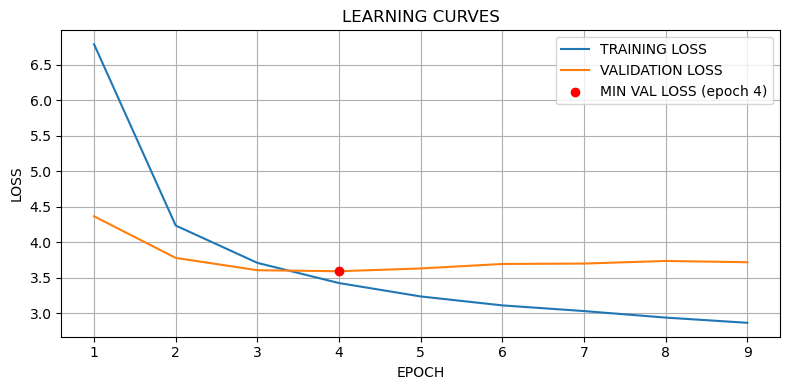

In [ ]:
with open("history1.pkl", "rb") as f:
    history = pickle.load(f)


loss = history.get("loss", [])
val_loss = history.get("val_loss", [])


print("Epochs:", len(loss))
print("Initial loss:", loss[:5])
print("Initial val loss:", val_loss[:5])


plt.figure(figsize=(8, 4))
plt.plot(range(1, len(loss) + 1), loss, label='TRAINING LOSS')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='VALIDATION LOSS')

if val_loss:
    min_epoch = val_loss.index(min(val_loss)) + 1
    plt.scatter(min_epoch, min(val_loss), color='red', zorder=5,
                label=f'MIN VAL LOSS (epoch {min_epoch})')

plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.title('LEARNING CURVES')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
file_path = ".../history-with-attention-EN.txt"

loss = []
val_loss = []

with open(file_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

for line in lines:
    train_loss_match = re.search(r" loss: ([0-9]+\.[0-9]+) ", line)
    val_loss_match = re.search(r"val_loss: ([0-9]+\.[0-9]+)", line)

    if train_loss_match and val_loss_match:
        loss.append(float(train_loss_match.group(1)))
        val_loss.append(float(val_loss_match.group(1)))

print("Epochs:", len(loss))
print("Initial loss:", loss[:5])
print("Initial val loss:", val_loss[:5])

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(loss) + 1), loss, label='TRAINING LOSS')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='VALIDATION LOSS')

if val_loss:
    min_epoch = val_loss.index(min(val_loss)) + 1
    plt.scatter(min_epoch, min(val_loss), color='red', zorder=5, label=f'MIN VAL LOSS (epoch {min_epoch})')

plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.title('LEARNING CURVES')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '.../history-with-attention-EN.txt'

In [ ]:
def extract_features(image_paths): # the extract_features function takes a list of image paths rather than a single path
                                   # and extracts features for each image, using a pre-trained VGG16 model
                                   # the results are stored in a dictionary, where each image ID is associated with its features
    # Load the VGG16 model
    base_model = VGG16()
    # Define the feature extraction model
    #model = Model(inputs=base_model.input, outputs=model.layers[-2].output)
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

    # Initialize an empty dictionary to store features for each image
    features = {}

    # Loop through each image path
    for image_path in image_paths:
        # Load the image and preprocess it
        image = load_img(image_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        # Add batch dimension
        image = np.expand_dims(image, axis=0)

        # Extract features using the model
        feature = model.predict(image)

        # Get the image ID from the filename
        image_id = os.path.splitext(os.path.basename(image_path))[0]

        # Store the features in the dictionary
        features[image_id] = feature

    return features

In [ ]:
def words_for_id(integer, tokenizers):
    # Initialize a list to store matching words
    matching_words = []

    # Iterate over each tokenizer
    for tokenizer in tokenizers:
        # Check if the integer exists in the current tokenizer
        if integer in tokenizer.word_index:
            # Append the corresponding word to the list
            matching_words.append(tokenizer.index_word[integer])

    # Return the list of matching words
    return matching_words

In [ ]:
def generate_desc(model, tokenizers, photo, max_len, temperature=1.0):
    all_predictions = []

    for j, tokenizer in enumerate(tokenizers):
        in_text = 'startseq'
        predicted_words = []

        for _ in range(max_len):
            # Tokenize current sequence
            sequence = tokenizer.texts_to_sequences([in_text])[0]
            padded_sequence = pad_sequences([sequence], maxlen=max_len)

            # 8 visual and 9 textual inputs
            inputs = [photo] * 8
            inputs += [np.zeros((1, max_len)) for _ in range(9)]

            # Update the text input for the current tokenizer
            inputs[8 + j] = padded_sequence

            # Predict next word
            yhat = model.predict(inputs, verbose=0)

            # Extract the prediction for the output corresponding to the current tokenizer
            yhat = yhat[j]

            # Ensure that yhat should be 1-dimensional
            yhat = yhat.flatten()

            # Apply temperature to logits before Softmax
            yhat = np.log(yhat + 1e-10) / temperature # stabilize the calculation with a small value
            yhat = np.exp(yhat) / np.sum(np.exp(yhat)) # calculate probability with Softmax

            # Select the most probable word
            next_index = np.random.choice(len(yhat), p=yhat)
            next_word = tokenizer.index_word.get(next_index, None)

            # Check if the next word is not 'endseq'
            if next_word is not None and next_word != 'endseq':
                predicted_words.append(next_word)
                in_text += ' ' + next_word
            else:
                break

        # Join the predicted words and remove 'endseq'
        prediction = ' '.join(predicted_words).replace(' endseq', '').strip()
        all_predictions.append(prediction)

    return all_predictions

In [ ]:
model = define_model(max_len, vocab_size, Nmax, group_size=8)

model.load_weights('.../model-weights-with-attention-EN.h5')

for i, layer in enumerate(model.inputs):
    print(f"Input {i+1}: {layer.shape}")

# Initialize BERT for semantic analysis (NOT for generation)
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")

# Function to calculate semantic score based on BERT
def calculate_semantic_score(prediction):
    inputs = bert_tokenizer(prediction, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss
        perplexity = torch.exp(loss).item() # perplexity is the exponential of loss
    return -perplexity # the greater the perplexity, the less sensible the sentence is

# Function to calculate the score based only on semantic content
def calculate_heuristic_score(prediction):
    if prediction.strip() == "": # if the prediction is empty, give a very low score so an empty sentence will never be selected
        return -float('inf')
    return calculate_semantic_score(prediction)

tokenizers = [Tokenizer() for _ in range(9)]
for tokenizer in tokenizers:
    tokenizer.fit_on_texts([caption for _, captions in new_captions_dict.items() for caption in captions])

predicted_captions = []
actual_captions = []
image_names = []

# CSV file setup
csv_file_path = '.../output-semantic-with-attention-EN.csv' # ---> Sebastiano: Insert path where to save csv file (better if in the same folder of the script, not in that of data)

with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image Prefix', 'Predicted Report', 'Actual Report'])

    # Group images based on prefix (first 4 digits of name)
    prefix_groups = {}
    for image in test_images:
        prefix = image[:4]
        if prefix not in prefix_groups:
            prefix_groups[prefix] = []
        prefix_groups[prefix].append(image)

    # Process each group
    for prefix, images in prefix_groups.items():
        print(f"Frames of CT scan number: {prefix}")
        all_captions_list = [new_captions_dict[image] for image in images]

        image_paths = [os.path.join(image_dataset_path, image + '.jpg') for image in images]
        image_features = extract_features(image_paths)

        photos = [np.array([image_features[image][0]]) for image in images]

        # Generates predictions for each of the 9 (i.e., Nmax) positions
        group_predictions = [[] for _ in range(9)]

        for photo, image in zip(photos, images):
            predictions = generate_desc(model, tokenizers, photo, max_len)

            captions_list = new_captions_dict[image]
            num_actual_captions = len(captions_list)
            # If there are less than 9 actual captions, insert empty strings for the remaining positions
            if num_actual_captions < 9:
                for i in range(num_actual_captions, 9):
                    predictions[i] = ""

            # Add prediction for each frame
            for i in range(9):
                if i < len(predictions):
                    group_predictions[i].append(predictions[i])

            for j, prediction in enumerate(predictions):
                if j < num_actual_captions:
                    print(f"Prediction for predictor {j + 1}: {prediction}")
                else:
                    print(f"Prediction for predictor {j + 1}: (empty)")
            print('---')

        # Selecting the best prediction for each position using BERT
        best_predictions = [""] * 9
        best_scores = [-1] * 9

        for i in range(9):
            best_prediction_for_position = None
            found_valid_prediction = False

            for prediction in group_predictions[i]:
                # Exclude empty predictions
                if not prediction.strip():
                    continue

                found_valid_prediction = True # find a valid prediction

                # Calculate heuristic score based on semantic content
                heuristic_score = calculate_heuristic_score(prediction)

                # Select the prediction with the highest semantic score for each position
                if heuristic_score > best_scores[i]:
                    best_scores[i] = heuristic_score
                    best_prediction_for_position = prediction

            # If there are no valid predictions for a position, choose the first prediction associated with the specific predictor
            if not found_valid_prediction or best_prediction_for_position is None:
                if group_predictions[i]:
                    best_prediction_for_position = group_predictions[i][0]
                else:
                    best_prediction_for_position = ""

            best_predictions[i] = best_prediction_for_position

        # Add the best prediction for each position to the final list
        predicted_captions.append(best_predictions)

        # Extract the actual report from the original captions
        actual_captions.append([word for word in all_captions_list[0][0].split() if word not in ['startseq', 'endseq']])

        print()
        print(f"Best prediction for frames of CT scan number {prefix}: {best_predictions}")
        print()
        print("Predicted -> ", best_predictions)
        print("Actual -> ", [' '.join([word for word in caption.split() if word not in ['startseq', 'endseq']]) for caption in all_captions_list[0]])
        print('*********************************************************************')
        print()

        image_names.append(prefix)
        filtered_preds = [element for element in best_predictions if element]
        best_preds = " ".join(filtered_preds)
        actuals = " ".join([' '.join([word for word in caption.split() if word not in ['startseq', 'endseq']]) for caption in all_captions_list[0]])

        writer.writerow([prefix, best_preds, actuals])

In [ ]:
# Function to clean illegal characters
def clean_text(text):
    if isinstance(text, str):
        # Remove illegal characters for Excel (control characters except newline/tab)
        return re.sub(r'[\x00-\x08\x0B\x0C\x0E-\x1F]', '', text)
    return text

In [ ]:
csv_file_path = '.../output-semantic-with-attention-EN.csv'
df = pd.read_csv(csv_file_path)

file_path = '.../output-semantic-with-attention-EN.xlsx' 
df = df.map(clean_text)
df.to_excel(file_path, index=False, engine='openpyxl')
df = pd.read_excel(file_path)

# Initialize the Rouge Scorer
rouge = Rouge()

# Initialize lists to store Scores
bleu1_scores = []
bleu2_scores = []
bleu3_scores = []
bleu4_scores = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []
meteor_scores = []

# Function to calculate BLEU Scores with different n-grams
def calculate_bleu_scores(reference, hypothesis):
    smoothing_function = SmoothingFunction().method1
    bleu1 = sentence_bleu([reference], hypothesis, weights=(1, 0, 0, 0), smoothing_function=smoothing_function)
    bleu2 = sentence_bleu([reference], hypothesis, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function)
    bleu3 = sentence_bleu([reference], hypothesis, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing_function)
    bleu4 = sentence_bleu([reference], hypothesis, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function)
    return bleu1, bleu2, bleu3, bleu4

# Iterate through each row to calculate the Scores
for index, row in df.iterrows():
    reference = row['Actual Report'].split()
    hypothesis = row['Predicted Report'].split()

    # Calculate BLEU Scores
    bleu1, bleu2, bleu3, bleu4 = calculate_bleu_scores(reference, hypothesis)
    bleu1_scores.append(bleu1)
    bleu2_scores.append(bleu2)
    bleu3_scores.append(bleu3)
    bleu4_scores.append(bleu4)

    # Calculate ROUGE Scores
    rouge_scores = rouge.get_scores(' '.join(hypothesis), ' '.join(reference))[0]
    rouge1_scores.append(rouge_scores['rouge-1']['f'])
    rouge2_scores.append(rouge_scores['rouge-2']['f'])
    rougeL_scores.append(rouge_scores['rouge-l']['f'])

    # Calculate METEOR Score
    meteor = meteor_score([reference], hypothesis)
    meteor_scores.append(meteor)

# Add the Scores to the dataframe
df['BLEU-1'] = bleu1_scores
df['BLEU-2'] = bleu2_scores
df['BLEU-3'] = bleu3_scores
df['BLEU-4'] = bleu4_scores
df['ROUGE-1'] = rouge1_scores
df['ROUGE-2'] = rouge2_scores
df['ROUGE-L'] = rougeL_scores
df['METEOR'] = meteor_scores

# Calculate global averages
global_bleu1 = df['BLEU-1'].mean()
global_bleu2 = df['BLEU-2'].mean()
global_bleu3 = df['BLEU-3'].mean()
global_bleu4 = df['BLEU-4'].mean()
global_rouge1 = df['ROUGE-1'].mean()
global_rouge2 = df['ROUGE-2'].mean()
global_rougeL = df['ROUGE-L'].mean()
global_meteor = df['METEOR'].mean()

# Append the global averages to the dataframe
df.loc['Global Average'] = [''] * (len(df.columns) - 8) + [global_bleu1, global_bleu2, global_bleu3, global_bleu4, global_rouge1, global_rouge2, global_rougeL, global_meteor]

# Save the updated dataframe to a new Excel file
output_file_path = '.../output-semantic&scores-with-attention-EN.xlsx' # ---> Sebastiano: Insert path where to save xlsx file (better if in the same folder of the script, not in that of data)

df.to_excel(output_file_path, index=False)

# Load the workbook to format the last row
wb = openpyxl.load_workbook(output_file_path)
ws = wb.active

# Apply red font color to the last row (Global Average)
last_row = ws.max_row
red_font = Font(color="FF0000", bold=True)
for cell in ws[last_row]:
    cell.font = red_font

# Save the workbook with formatting
wb.save(output_file_path)

# Display the updated dataframe
print(df.head())